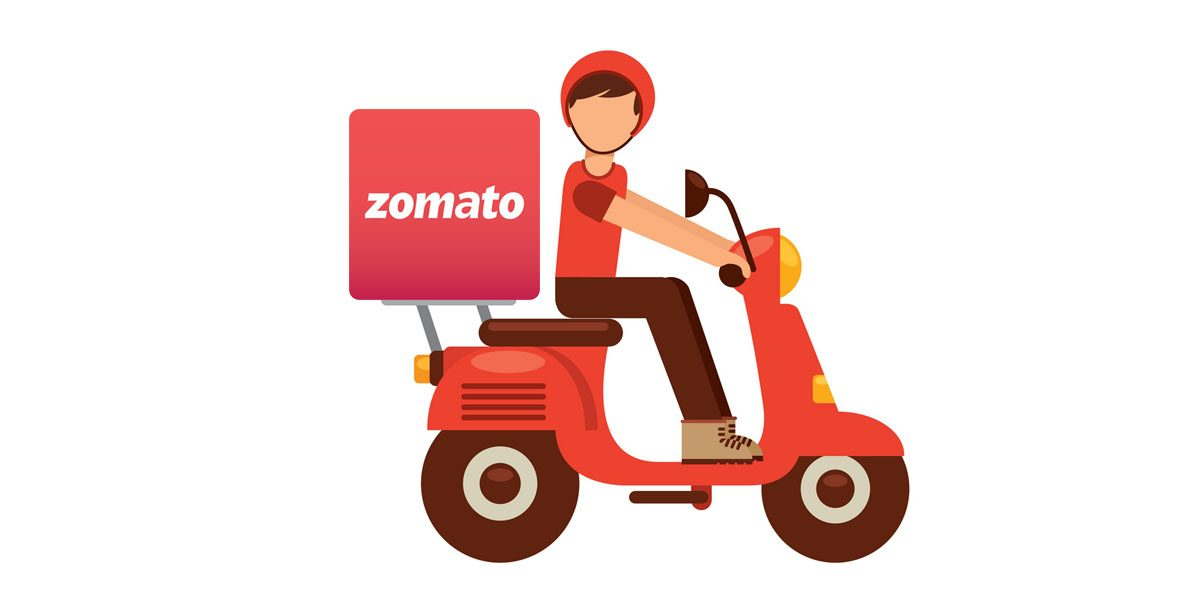

Bangalore(officially known as Bengaluru) is the capital and largest city of the Indian state of Karnataka.

With a population of over 15 million, Bangalore is the third largest city in India and 27th largest city in the world. Bangalore is one of the most ethnically diverse cities in the country, with over 51% of the city’s population being migrants from other parts of India.

Bangalore is sometimes referred to as the “Silicon Valley of India”(or “IT capital of India”) because of its role as the nation’s leading information technology(IT) exporter.

Bangalore has a unique food culture. Restaurants from all over the world can be found here in Bengaluru, with various kind of cuisines.

Some might even say that Bangalore is the best place for foodies. The food industry is always at a rise in Bangalore, with 12,000 plus restaurants currently active in the city, the number is still increasing. The growing number of restaurants and dishes in Bangalore is what attracts me to inspect the data to get some insights, some interesting facts and figures.

## Data Description

* url : This feature contains the url of the restaurant on the Zomato website
* address : This feature contains the address of the restaurant in Bangalore
* name : This feature contains the name of the restaurant
* online_order : whether online ordering is available in the restaurant or not
* book_table : table book option available or not
* rate : contains the overall rating of the restaurant out of 5
* votes : contains total number of upvotes for the restaurant
* phone : contains the phone number of the restaurant
* location : contains the neighborhood in which the restaurant is located
* rest_type : restaurant type
* dish_liked : dishes people liked in the restaurant
* cuisines : food styles, separated by comma
* approx_cost(for two people) : contains the approximate cost of meal for two people
* reviews_list : list of tuples containing reviews for the restaurant, each tuple       consists of two values, rating and review by the customer
* menu_item : contains list of menus available in the restaurant
* listed_in(type) : type of meal
* listed_in(city) : contains the neighborhood in which the restaurant is located

## Importing the libraries

In [148]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.utils import shuffle
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
import json
import joblib

# Setting the working directory
# os.chdir(r'../')
os.chdir(r'F:\NTU Learn\DS Thinking\ntu_sd6101_team_project')

# Pandas option:
pd.set_option('max_colwidth',40)  # This allows us to see the data upto 40 characters per each column

pd.options.display.max_columns = None   # This allows us to see all the columns without collapsing 


# The below code is for for showing all expressions, not just the result of the last expression
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Table styles, this below code is for decorating the dataframe no functional use.
table_styles = {
        'cerulean_palette' : [
        dict(selector="th", props=[("color", "#FFFFFF"), ("background", "#004D80"), ("text-transform", "capitalize")]),
        dict(selector="td", props=[("color", "#333333")]),
        dict(selector="table", props=[("font-family", 'Arial'), ("border-collapse", "collapse")]),
        dict(selector='tr:nth-child(even)', props=[('background', '#D3EEFF')]),
        dict(selector='tr:nth-child(odd)', props=[('background', '#FFFFFF')]),
        dict(selector="th", props=[("border", "1px solid #0070BA")]),
        dict(selector="td", props=[("border", "1px solid #0070BA")]),
        dict(selector="tr:hover", props=[("background", "#80D0FF")])
    ]
}

# Filtering all the warnings:
warnings.filterwarnings('ignore')

## Data Preprocessing

In [161]:
data = pd.read_csv('data/zomato.csv', na_values=['-','',' ','NEW','[]'])

In [166]:
# sampling
data_shuffled = shuffle(data, random_state=42)
authors_list = ['cyh','axh','psq','xjl','czx']
for i in range(len(authors_list)):
    author = authors_list[i]
    subset = data_shuffled.iloc[i*1000:(i+1)*1000]
    # print(subset.shape)
    indexes = subset.index.to_list()
    os.makedirs(f'data/subset_{author}', exist_ok=True)
    subset.to_csv(f'data/subset_{author}/zomato_subset_{author}.csv', index=True)
    with open(f'data/subset_{author}/indexes_{author}.json', 'w') as f:
        json.dump(indexes, f)

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         41665 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 44

In [108]:
100*data.isnull().sum()/len(data)

url                             0.000000
address                         0.000000
name                            0.000000
online_order                    0.000000
book_table                      0.000000
rate                           19.436549
votes                           0.000000
phone                           2.335789
location                        0.040606
rest_type                       0.438927
dish_liked                     54.291626
cuisines                        0.087012
approx_cost(for two people)     0.669026
reviews_list                   14.685693
menu_item                      76.603438
listed_in(type)                 0.000000
listed_in(city)                 0.000000
dtype: float64

In [ ]:
data

In [109]:
def func1(string):
    l=string.split(", ")
    
    if "Afghan" in l:
        l=list(map(lambda x: x.replace('Afghan', 'Afghani'), l))
        
    if "Bubble Tea" in l:
        l=list(map(lambda x: x.replace('Bubble Tea', 'Beverages'), l))
        
    if "Coffee" in l:
        l=list(map(lambda x: x.replace('Coffee', 'Beverages'), l))
        
    if "Cafe" in l:
        l=list(map(lambda x: x.replace('Cafe', 'Beverages'), l))
       
    if "Tea" in l:
        l=list(map(lambda x: x.replace('Tea', 'Beverages'), l))
        
    if "Bubble Beverages" in l:
        l=list(map(lambda x: x.replace('Bubble Beverages', 'Beverages'), l))
       
    if "Ice Cream" in l:
        l=list(map(lambda x: x.replace('Ice Cream', 'Desserts'), l))
        
    if "Mithai" in l:
        l=list(map(lambda x: x.replace('Mithai', 'Desserts'), l))
      
    if "Bar Food" in l:
        l=list(map(lambda x: x.replace('Bar Food', 'Fast Food'), l))
        
    if "Burger" in l:
        l=list(map(lambda x: x.replace('Burger', 'Fast Food'), l))
       
    if "Finger Food" in l:
        l=list(map(lambda x: x.replace('Finger Food', 'Fast Food'), l))
        
    if "Momos" in l:
        l=list(map(lambda x: x.replace('Momos', 'Fast Food'), l))
        
    if "Rolls" in l:
        l=list(map(lambda x: x.replace('Rolls', 'Fast Food'), l))
    
    if "Wraps" in l:
        l=list(map(lambda x: x.replace('Wraps', 'Fast Food'), l))
        
    if "Street Food" in l:
        l=list(map(lambda x: x.replace('Street Food', 'Fast Food'), l))
 
    if "Juices" in l:
        l=list(map(lambda x: x.replace('Juices', 'Healthy Food'), l))
       
    if "Salad" in l:
        l=list(map(lambda x: x.replace('Salad', 'Healthy Food'), l))
     
    if "Sandwich" in l:
        l=list(map(lambda x: x.replace('Sandwich', 'Healthy Food'), l))
      
    if "Grill" in l:
        l=list(map(lambda x: x.replace('Grill', 'BBQ'), l))
    
    if "Steak" in l:
        l=list(map(lambda x: x.replace('Steak', 'BBQ'), l))
        
    if "Sushi" in l:
        l=list(map(lambda x: x.replace('Sushi', 'Japanese'), l))
        
    if "Tex-Mex" in l:
        l=list(map(lambda x: x.replace('Tex-Mex', 'Mexican'), l))
        
    if "Roast Chicken" in l:
        l=list(map(lambda x: x.replace('Roast Chicken', 'Chinese'), l))
        
    if "Charcoal Chicken" in l:
        l=list(map(lambda x: x.replace('Charcoal Chicken', 'Chinese'), l))
        
    if "Pizza" in l:
        l=list(map(lambda x: x.replace('Pizza', 'Italian'), l))
        
    if "Biryani" in l:
        l=list(map(lambda x: x.replace('Biryani', 'South Indian'), l))
        
    if "Kebab" in l:
        l=list(map(lambda x: x.replace('Kebab', 'North Indian'), l))
    
    return ", ".join(set(l))

In [127]:
def process_features(input_df):
    sample_df = input_df.copy()
    df = sample_df.drop([ 'url','phone','reviews_list','rest_type'],axis=1)

    df['cuisines'].fillna('Other', inplace=True)
    df["cuisines"]=df["cuisines"].apply(lambda x: func1(str(x)))
    df['votes'] = df['votes'].astype('int')
    df['approx_cost(for two people)']=df['approx_cost(for two people)'].str.replace(",","").astype(float)
    df[-df['rate'].isna()]['rate']=df[-df['rate'].isna()]['rate'].str.replace("/5","").astype(float)
    col = ["listed_in(city)","listed_in(type)"]
    ser = df.groupby(col)['approx_cost(for two people)'].transform('median')
    df['approx_cost(for two people)']=df['approx_cost(for two people)'].fillna(ser)
    df['Cost_Per_Person'] = df['approx_cost(for two people)']/2
    df.drop(columns='approx_cost(for two people)', inplace=True)

    def p_category(price):
        if price<=100.0:
            return "Cheap"
        elif price<=250.0:
            return "Resonable"
        elif price<=500.0:
            return "Affordable"
        else:
            return "Expensive"

    df["rate"]=df["rate"].str[0:3].astype(float)
    df["Price_Category"]=df["Cost_Per_Person"].apply(p_category)

    # whether menu is available or not

    df['menu_item'].fillna('No',inplace=True)
    df["Menu"]=df["menu_item"].map(lambda x: "Yes" if x != 'No' else "No")

    #no of dishes liked by customer at a restaurant
    df[df['dish_liked'].isnull()]['dish_liked'] = ''
    df['dish_liked']=df['dish_liked'].map(lambda x:0 if x=="" else len(str(x).split(", ")))

    # No of varieties served at a restaurant

    df['No_of_Varieties']=df['cuisines'].apply(lambda x:len(str(x).split(", ")))
    change={'name':'Name',
            'address':'Address',
            'online_order':"Delivery",
            'book_table':"Booking", 
            'rate':"Rating", 
            'dish_liked':"No_of_Best_Sellers",
            'cuisines':"Cuisines", 
            'approx_cost(for two people)':"Average_Cost", 
            'listed_in(type)':"Type",
            'listed_in(city)':"City"}

    df.rename(columns=change,inplace=True)
    df.reset_index(drop=True,inplace=True)

    display_df=df[['Name','Address','Menu','Delivery', 'Booking', 'No_of_Best_Sellers', 'No_of_Varieties', 'Cuisines',
        'Cost_Per_Person', 'Type', 'City', 'Rating','Price_Category']]

    multi_label=display_df["Cuisines"].str.split(", ")
    mlb = MultiLabelBinarizer()
    inter_data=mlb.fit_transform(multi_label)
    multi_label_df=pd.DataFrame(inter_data,columns=mlb.classes_)
    display= pd.concat([display_df,multi_label_df],axis=1)

    one_hot=display[['Delivery', 'Booking', 'City']]
    numeric=display[['No_of_Best_Sellers', 'No_of_Varieties', 'Cost_Per_Person', 'Rating']]

    encoder= OneHotEncoder()
    one_hot_df=pd.DataFrame(encoder.fit_transform(one_hot).toarray(),index=list(display.index))

    df_inter=pd.concat([numeric,multi_label_df.iloc[list(display.index),:],one_hot_df],axis=1)
    df_inter.reset_index(drop=True,inplace=True)
    df_inter.head()

    return df_inter

In [133]:
data_features = process_features(data)
data_features

,No_of_Best_Sellers,No_of_Varieties,Cost_Per_Person,Rating,Afghani,African,American,Andhra,Arabian,Asian,Assamese,Australian,Awadhi,BBQ,Bakery,Belgian,Bengali,Beverages,Bihari,Bohri,British,Burmese,Cantonese,Chettinad,Chinese,Continental,Desserts,Drinks Only,European,Fast Food,French,German,Goan,Greek,Gujarati,Healthy Food,Hot dogs,Hyderabadi,Indian,Indonesian,Iranian,Italian,Japanese,Jewish,Kashmiri,Kerala,Konkan,Korean,Lebanese,Lucknowi,Maharashtrian,Malaysian,Malwani,Mangalorean,Mediterranean,Mexican,Middle Eastern,Modern Indian,Mongolian,Mughlai,Naga,Nepalese,North Eastern,North Indian,Oriya,Other,Paan,Pan Asian,Parsi,Portuguese,Rajasthani,Raw Meats,Russian,Seafood,Sindhi,Singaporean,South American,South Indian,Spanish,Sri Lankan,Tamil,Thai,Tibetan,Turkish,Vegan,Vietnamese,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,7,3,400.0,4.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,3,400.0,4.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,3,400.0,3.8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2,150.0,3.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,2,300.0,3.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51712,1,1,750.0,3.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51713,1,1,300.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51714,1,1,1000.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51715,3,1,1250.0,4.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

In [140]:
sample_df = data_features[-data_features["Rating"].isna()]
sample_df= sample_df[data["votes"]>=30]
neg_sample_df = data_features.drop(sample_df.index)
sample_df.reset_index(drop=True,inplace=True)
neg_sample_df.reset_index(drop=True,inplace=True)

print(f'we select {sample_df.shape[0]} as training sample for first task, and the rest {data.shape[0]-sample_df.shape[0]} as the samples to be modified for the first task')

we select 28621 as training sample for first task, and the rest 23096 as the samples to be modified for the first task


In [141]:
neg_sample_df.shape, sample_df.shape

((23096, 120), (28621, 120))

In [146]:
neg_sample_df.Rating.mean(), sample_df.Rating.mean()

(np.float64(3.3992946948788716), np.float64(3.8376995912092515))

In [144]:
sample_df.to_csv('data/task1_training_samples_features_display.csv',index=False)
neg_sample_df.to_csv('data/task1_negative_samples_features_display.csv',index=False)

Statistics

In [121]:
df['votes'].quantile(0.2)

np.float64(57.0)

In [122]:
df[df['votes']<=30].shape[0], df[df['votes']>30].shape[0]

(249, 28372)

array([[<Axes: title={'center': 'Rating'}>,
        <Axes: title={'center': 'votes'}>],
       [<Axes: title={'center': 'No_of_Best_Sellers'}>,
        <Axes: title={'center': 'Cost_Per_Person'}>],
       [<Axes: title={'center': 'No_of_Varieties'}>, <Axes: >]],
      dtype=object)

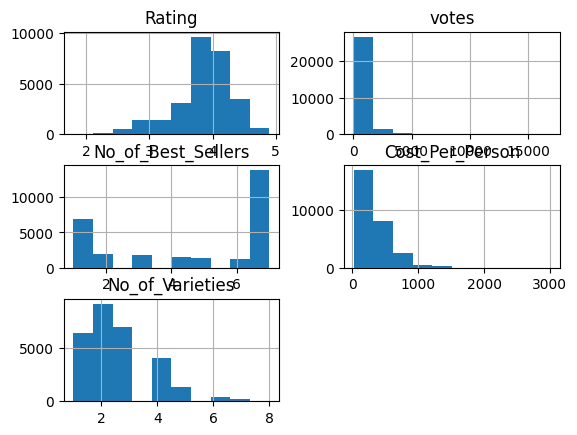

In [123]:
df.hist()

In [124]:
# cuisines barplot
cuisine_set = set()
for i in df['cuisines']:
    for j in str(i).split(','):
        cuisine_set.add(j.strip())

cuisine_df = df.loc[:,['cuisines']].copy()
for i in cuisine_set:
    cuisine_df['has'+i] = 0

for i in cuisine_set:
    for j in range(cuisine_df.shape[0]):
        offer = str(cuisine_df.iloc[j, 0])
        if i in offer:
            cuisine_df.loc[j, 'has'+i] = 1

cuisine_df.drop(columns='cuisines', inplace=True)

count_list = []
for col in cuisine_df.columns:
    num = cuisine_df[col].sum()
    cuisine = col.replace('has','')
    dict1 = {'cuisine':cuisine, 'count':num}
    count_list.append(dict1)

count_df = pd.DataFrame(count_list)
count_df = count_df.sort_values(by='count', ascending=False).head(10)
ax = sns.barplot(y='cuisine', x='count', data=count_df, palette="Set1")

KeyError: 'cuisines'

## Observations from the above data 
* There are some unnecessary columns like url, address, phone number and location (As we already have location in listed_in(city) column.
* Menu_item is also not of use for us as it is empty for all the rows.
* Since approx cost for 2 people column name is very big, we can rename the same.
* Reviews list is not of use for us as we already have average rating in a separate column.



## Removing columns which are not of our use

In [95]:
df.drop(columns=['url','address','phone','reviews_list','menu_item'],inplace=True)
df.head()

,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,approx_cost(for two people),listed_in(type),listed_in(city)
0,Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, P...","North Indian, Mughlai, Chinese",800,Buffet,Banashankari
1,Spice Elephant,Yes,No,4.1/5,787,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirva...","Chinese, North Indian, Thai",800,Buffet,Banashankari
2,San Churro Cafe,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup...","Cafe, Mexican, Italian",800,Buffet,Banashankari
3,Addhuri Udupi Bhojana,No,No,3.7/5,88,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,Buffet,Banashankari
4,Grand Village,No,No,3.8/5,166,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,Buffet,Banashankari


### Renaming approx_cost column/listed_in(city)/listed_in(type) column to costfor2 and loction and type respectively.

In [96]:
df.rename(columns={'listed_in(city)':'location_1','approx_cost(for two people)':'costfor2','listed_in(type)':'type'},inplace=True)

In [97]:
df

,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,costfor2,type,location_1
0,Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, P...","North Indian, Mughlai, Chinese",800,Buffet,Banashankari
1,Spice Elephant,Yes,No,4.1/5,787,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirva...","Chinese, North Indian, Thai",800,Buffet,Banashankari
2,San Churro Cafe,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup...","Cafe, Mexican, Italian",800,Buffet,Banashankari
3,Addhuri Udupi Bhojana,No,No,3.7/5,88,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,Buffet,Banashankari
4,Grand Village,No,No,3.8/5,166,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,Buffet,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...,...
51712,Best Brews - Four Points by Sheraton...,No,No,3.6 /5,27,Whitefield,Bar,NaN,Continental,"1,500",Pubs and bars,Whitefield
51713,Vinod Bar And Restaurant,No,No,NaN,0,Whitefield,Bar,NaN,Finger Food,600,Pubs and bars,Whitefield
51714,Plunge - Sheraton Grand Bengaluru Wh...,No,No,NaN,0,Whitefield,Bar,NaN,Finger Food,"2,000",Pubs and bars,Whitefield
51715,Chime - Sheraton Grand Bengaluru Whi...,No,Yes,4.3 /5,236,"ITPL Main Road, Whitefield",Bar,"Cocktails, Pizza, Buttermilk",Finger Food,"2,500",Pubs and bars,Whitefield


In [98]:
# In the above Df we can see that we have 2 locations, location_1 and location, let's drop location
df.drop(columns=['location'],inplace=True)

In [99]:
df.rename(columns={'location_1':'location'},inplace=True)

 ## Basic exploration and Data wrangling

In [100]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          51717 non-null  object
 1   online_order  51717 non-null  object
 2   book_table    51717 non-null  object
 3   rate          43942 non-null  object
 4   votes         51717 non-null  int64 
 5   rest_type     51490 non-null  object
 6   dish_liked    23639 non-null  object
 7   cuisines      51672 non-null  object
 8   costfor2      51371 non-null  object
 9   type          51717 non-null  object
 10  location      51717 non-null  object
dtypes: int64(1), object(10)
memory usage: 4.3+ MB


,votes
count,51717.000000
mean,283.697527
std,803.838853
min,0.000000
25%,7.000000
50%,41.000000
75%,198.000000
max,16832.000000


In [101]:
df.shape

(51717, 11)

In [102]:
df.describe(include='all')

,name,online_order,book_table,rate,votes,rest_type,dish_liked,cuisines,costfor2,type,location
count,51717,51717,51717,43942,51717.000000,51490,23639,51672,51371,51717,51717
unique,8792,2,2,64,NaN,93,5271,2723,70,7,30
top,Cafe Coffee Day,Yes,No,NEW,NaN,Quick Bites,Biryani,North Indian,300,Delivery,BTM
freq,96,30444,45268,2208,NaN,19132,182,2913,7576,25942,3279
mean,NaN,NaN,NaN,NaN,283.697527,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,803.838853,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,41.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,198.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
df.isna().sum()
(df.isna().sum()/len(df))*100

name                0
online_order        0
book_table          0
rate             7775
votes               0
rest_type         227
dish_liked      28078
cuisines           45
costfor2          346
type                0
location            0
dtype: int64

name             0.000000
online_order     0.000000
book_table       0.000000
rate            15.033741
votes            0.000000
rest_type        0.438927
dish_liked      54.291626
cuisines         0.087012
costfor2         0.669026
type             0.000000
location         0.000000
dtype: float64

**Issues with dish_liked**
* There are more than 50% missing values.
* The data is a long string with mutiple dishes which doesn't give proper idea.
* Since there is huge number of missing values imputing with mode will create a huge bias.
* The best option to handle this is to remove this column.


In [104]:
# Let's just find the most liked food item 
df['dish_liked'].value_counts()

dish_liked
Biryani                                                                                     182
Chicken Biryani                                                                              73
Friendly Staff                                                                               69
Waffles                                                                                      68
Paratha                                                                                      57
                                                                                           ... 
Masala Dosa, Filter Coffee, Curd Rice                                                         1
Dal Makhani, Galauti Kebab, Dum Biryani, Rasgulla, Fish, Garlic Kheer, Tandoori Broccoli      1
Pasta, Coffee, Mocktails, Pizza, Sandwiches, Macaroon, Croissants                             1
Rolls, Butter Chicken, Tandoori Momos, Tangdi Kabab, Tandoori Roti, Paratha, Soya Chaap       1
Chocolate Momos, Burgers, Noo

In [105]:
# The most liked food item in the restaurants is Biryani
# Let's check how many restaurants biryani is good

dish_liked=pd.DataFrame(df['dish_liked'].value_counts())
dish_liked
dish_liked.reset_index(inplace=True)

,count
dish_liked,
Biryani,182
Chicken Biryani,73
Friendly Staff,69
Waffles,68
Paratha,57
...,...
"Masala Dosa, Filter Coffee, Curd Rice",1
"Dal Makhani, Galauti Kebab, Dum Biryani, Rasgulla, Fish, Garlic Kheer, Tandoori Broccoli",1
"Pasta, Coffee, Mocktails, Pizza, Sandwiches, Macaroon, Croissants",1


In [106]:
dish_liked['dish_liked'].str.contains('biryani',case=False).count()

np.int64(5271)

*Most liked food in restaurants is Biryani. Total of 5271 restaurants biryani has been most liked by the customers*

In [107]:
# Now let's remove the column of dish_liked
df.drop(columns=['dish_liked'])
df.drop(columns=['dish_liked'],inplace=True)

,name,online_order,book_table,rate,votes,rest_type,cuisines,costfor2,type,location
0,Jalsa,Yes,Yes,4.1/5,775,Casual Dining,"North Indian, Mughlai, Chinese",800,Buffet,Banashankari
1,Spice Elephant,Yes,No,4.1/5,787,Casual Dining,"Chinese, North Indian, Thai",800,Buffet,Banashankari
2,San Churro Cafe,Yes,No,3.8/5,918,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,Buffet,Banashankari
3,Addhuri Udupi Bhojana,No,No,3.7/5,88,Quick Bites,"South Indian, North Indian",300,Buffet,Banashankari
4,Grand Village,No,No,3.8/5,166,Casual Dining,"North Indian, Rajasthani",600,Buffet,Banashankari
...,...,...,...,...,...,...,...,...,...,...
51712,Best Brews - Four Points by Sheraton...,No,No,3.6 /5,27,Bar,Continental,"1,500",Pubs and bars,Whitefield
51713,Vinod Bar And Restaurant,No,No,NaN,0,Bar,Finger Food,600,Pubs and bars,Whitefield
51714,Plunge - Sheraton Grand Bengaluru Wh...,No,No,NaN,0,Bar,Finger Food,"2,000",Pubs and bars,Whitefield
51715,Chime - Sheraton Grand Bengaluru Whi...,No,Yes,4.3 /5,236,Bar,Finger Food,"2,500",Pubs and bars,Whitefield


In [108]:
# Let's now handle rate column
df['rate'].value_counts()
df['rate'].unique()

rate
NEW       2208
3.9/5     2098
3.8/5     2022
3.7/5     2011
3.9 /5    1874
          ... 
2.2 /5       7
2.0 /5       7
2.0/5        4
1.8 /5       3
1.8/5        2
Name: count, Length: 64, dtype: int64

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', nan, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

**Issues with rate column**
* All the values are in string format rather than float.
* There are non numerical values like 'NEW' and '-'.

In [109]:
def cleaning_rate(val):
    if(val=='NEW' or val=='-'):
        return np.nan
    else:
        return float(str(val).split('/')[0])
    
df['rate']=df['rate'].apply(cleaning_rate)

In [110]:
df['rate'].value_counts()

rate
3.9    3972
3.8    3873
3.7    3821
3.6    3316
4.0    3183
4.1    2948
3.5    2784
3.4    2476
3.3    2310
4.2    2184
3.2    1873
4.3    1693
3.1    1561
4.4    1147
3.0    1023
2.9     802
4.5     656
2.8     600
2.7     307
4.6     300
2.6     260
4.7     167
2.5     101
2.4      70
4.8      66
4.9      55
2.3      51
2.2      26
2.1      24
2.0      11
1.8       5
Name: count, dtype: int64

<Axes: ylabel='rate'>

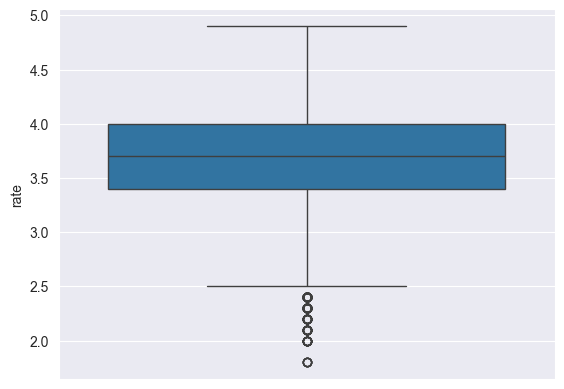

In [111]:
sns.set_style("darkgrid")
sns.boxplot(df['rate'])

In [112]:
# There is a presence of outliers in the data so it's a good idea to impute median in place of nan
df['rate']=df['rate'].fillna(df['rate'].median())
df['rate'].isna().sum()

np.int64(0)

In [113]:
df['rest_type'].value_counts()
rest_type_less=pd.DataFrame(df['rest_type'].value_counts())
rest_type_less[rest_type_less['count']<1000]
rest_type_less=rest_type_less[rest_type_less['count']<1000]

rest_type
Quick Bites                   19132
Casual Dining                 10330
Cafe                           3732
Delivery                       2604
Dessert Parlor                 2263
                              ...  
Dessert Parlor, Kiosk             2
Dessert Parlor, Food Court        2
Food Court, Beverage Shop         2
Sweet Shop, Dessert Parlor        1
Quick Bites, Kiosk                1
Name: count, Length: 93, dtype: int64

,count
rest_type,
Beverage Shop,867
Bar,697
Food Court,624
Sweet Shop,468
"Bar, Casual Dining",425
...,...
"Dessert Parlor, Kiosk",2
"Dessert Parlor, Food Court",2
"Food Court, Beverage Shop",2


**Observations**
* There are too many categories of rest type
* Data is not clean has many values which are comma separated.

*Best thing to clean this will be to combine rest_types which are less frequent to other category*

In [114]:
def combine_vals(val):
    if (val in rest_type_less.index):
        return 'Others'
    else:
        return val
df['rest_type']=df['rest_type'].apply(combine_vals)
df['rest_type']

0        Casual Dining
1        Casual Dining
2               Others
3          Quick Bites
4        Casual Dining
             ...      
51712           Others
51713           Others
51714           Others
51715           Others
51716           Others
Name: rest_type, Length: 51717, dtype: object

In [115]:
df['rest_type'].value_counts()

rest_type
Quick Bites           19132
Casual Dining         10330
Others                 9097
Cafe                   3732
Delivery               2604
Dessert Parlor         2263
Takeaway, Delivery     2037
Casual Dining, Bar     1154
Bakery                 1141
Name: count, dtype: int64

In [116]:
df['costfor2'].unique()
# df['costfor2'].astype('int')

array(['800', '300', '600', '700', '550', '500', '450', '650', '400',
       '900', '200', '750', '150', '850', '100', '1,200', '350', '250',
       '950', '1,000', '1,500', '1,300', '199', '80', '1,100', '160',
       '1,600', '230', '130', '50', '190', '1,700', nan, '1,400', '180',
       '1,350', '2,200', '2,000', '1,800', '1,900', '330', '2,500',
       '2,100', '3,000', '2,800', '3,400', '40', '1,250', '3,500',
       '4,000', '2,400', '2,600', '120', '1,450', '469', '70', '3,200',
       '60', '560', '240', '360', '6,000', '1,050', '2,300', '4,100',
       '5,000', '3,700', '1,650', '2,700', '4,500', '140'], dtype=object)

**Observations for costfor2**
* There are null values in the column.
* The datatype is object.
* We cannot directly astype the column into int because of the presence of commas in the values.

In [117]:
# Removing commas from the values
df['costfor2'].str.replace(",","")
df['costfor2']=df['costfor2'].str.replace(",","")

0         800
1         800
2         800
3         300
4         600
         ... 
51712    1500
51713     600
51714    2000
51715    2500
51716    1500
Name: costfor2, Length: 51717, dtype: object

In [118]:
# df['costfor2'].astype('int')

In [119]:
# Since we cannot typecast string nan values directly to integerts converting 
# column to numeric first

pd.to_numeric(df['costfor2'],errors='coerce')
df['costfor2']=pd.to_numeric(df['costfor2'],errors='coerce')

0         800.0
1         800.0
2         800.0
3         300.0
4         600.0
          ...  
51712    1500.0
51713     600.0
51714    2000.0
51715    2500.0
51716    1500.0
Name: costfor2, Length: 51717, dtype: float64

In [120]:
df['costfor2'].isna().sum()

np.int64(346)

* The costfor2 column has been converted to numerical value.
* Need to fill the nan values in it.

In [121]:
df[df['costfor2'].isna()]

,name,online_order,book_table,rate,votes,rest_type,cuisines,costfor2,type,location
1662,Papa Khan Rasoi,No,No,3.7,0,NaN,NaN,NaN,Delivery,Bannerghatta Road
1768,Innate,No,No,3.7,0,Delivery,Beverages,NaN,Delivery,Bannerghatta Road
1795,Super Chef's (New Royal treat),No,No,3.7,0,Quick Bites,"North Indian, Chinese, South Indian",NaN,Delivery,Bannerghatta Road
3069,Super Chef's (New Royal treat),No,No,3.7,0,Quick Bites,"North Indian, Chinese, South Indian",NaN,Delivery,Basavanagudi
3774,The Hub - Ibis Bengaluru,No,No,3.9,237,Others,Finger Food,NaN,Buffet,Bellandur
...,...,...,...,...,...,...,...,...,...,...
50940,Cinnabon,No,No,4.0,80,Quick Bites,"Beverages, American, Bakery",NaN,Desserts,Whitefield
51233,Mayas kitchen,No,No,3.7,0,Casual Dining,"South Indian, Chinese, Chettinad",NaN,Dine-out,Whitefield
51247,Mast Kalandar,No,No,2.6,76,Casual Dining,North Indian,NaN,Dine-out,Whitefield
51271,Karavalli Food Court,No,No,3.2,4,Casual Dining,South Indian,NaN,Dine-out,Whitefield


* Cost for 2 people depends on various factor one important factor would be type of restuarant.
* Let's first remove all the NAN values form rest_type
* We then impute the costfor2 based on the restaurant type

In [122]:
df.dropna(subset=['rest_type'],inplace=True)

In [123]:
df['rest_type'].unique()

array(['Casual Dining', 'Others', 'Quick Bites', 'Cafe', 'Delivery',
       'Dessert Parlor', 'Bakery', 'Takeaway, Delivery',
       'Casual Dining, Bar'], dtype=object)

In [124]:
# In rest_type takeaway,delivery and delivery are the same so combining those rows
# There is already a type casual dining so removing casual dining from casual dining,bar

def cleaning_restaurant_type(val):
    if (val=='Takeaway, Delivery'):
        return 'Delivery'
    elif (val=='Casual Dining, Bar'):
        return 'Bar'
    else:
        return val
    
df['rest_type'].apply(cleaning_restaurant_type).value_counts()
df['rest_type']=df['rest_type'].apply(cleaning_restaurant_type)

rest_type
Quick Bites       19132
Casual Dining     10330
Others             9097
Delivery           4641
Cafe               3732
Dessert Parlor     2263
Bar                1154
Bakery             1141
Name: count, dtype: int64

In [125]:
round(df.groupby('rest_type')['costfor2'].median(),0)

rest_type
Bakery             400.0
Bar               1200.0
Cafe               600.0
Casual Dining      700.0
Delivery           400.0
Dessert Parlor     300.0
Others             500.0
Quick Bites        300.0
Name: costfor2, dtype: float64

In [126]:
# converting the above into a dictionary for mapping

round(df.groupby('rest_type')['costfor2'].median(),0).to_dict()
mean_cost=round(df.groupby('rest_type')['costfor2'].mean(),0).to_dict()
median_cost=round(df.groupby('rest_type')['costfor2'].median(),0).to_dict()

{'Bakery': 400.0,
 'Bar': 1200.0,
 'Cafe': 600.0,
 'Casual Dining': 700.0,
 'Delivery': 400.0,
 'Dessert Parlor': 300.0,
 'Others': 500.0,
 'Quick Bites': 300.0}

In [127]:
df['costfor2'].fillna(df['rest_type'].map(median_cost),inplace=True)

In [128]:
# Nan values are replaced by median of that type of restaurant
df['costfor2'].isna().sum()

np.int64(0)

In [129]:
df['type'].unique()
df['type'].isna().sum()
df['type'].value_counts()

array(['Buffet', 'Cafes', 'Delivery', 'Desserts', 'Dine-out',
       'Drinks & nightlife', 'Pubs and bars'], dtype=object)

np.int64(0)

type
Delivery              25815
Dine-out              17693
Desserts               3584
Cafes                  1722
Drinks & nightlife     1101
Buffet                  878
Pubs and bars           697
Name: count, dtype: int64

In [130]:
df['cuisines'].unique()
df['cuisines'].nunique()
df['cuisines'].value_counts()

array(['North Indian, Mughlai, Chinese', 'Chinese, North Indian, Thai',
       'Cafe, Mexican, Italian', ...,
       'North Indian, Street Food, Biryani', 'Chinese, Mughlai',
       'North Indian, Chinese, Arabian, Momos'], dtype=object)

2712

cuisines
North Indian                                2899
North Indian, Chinese                       2361
South Indian                                1828
Biryani                                      909
Bakery, Desserts                             907
                                            ... 
North Indian, Chinese, Arabian, Momos          1
American, Thai, Healthy Food                   1
Andhra, Hyderabadi, Chinese                    1
Mughlai, Biryani, Chinese, North Indian        1
South Indian, Biryani, Chettinad, Juices       1
Name: count, Length: 2712, dtype: int64

In [131]:
def cleaning_cuisine(val):
    if (val=='North Indian, Chinese'):
        return 'Multicuisine'
    elif (val=='Bakery, Desserts'):
        return 'Desserts'
    elif (val=='Biryani'):
        return 'Multicuisine'
    elif ('Pizza' in str(val)):
        return 'Italian'
    elif (val=='North Indian'):
        return 'North Indian'
    elif (val=='South Indian'):
        return 'South Indian'
    else:
        return 'Others'
df['cuisines'].apply(cleaning_cuisine).value_counts()
df['cuisines']=df['cuisines'].apply(cleaning_cuisine)

cuisines
Others          40519
Multicuisine     3270
North Indian     2899
Italian          2067
South Indian     1828
Desserts          907
Name: count, dtype: int64

In [132]:
df

,name,online_order,book_table,rate,votes,rest_type,cuisines,costfor2,type,location
0,Jalsa,Yes,Yes,4.1,775,Casual Dining,Others,800.0,Buffet,Banashankari
1,Spice Elephant,Yes,No,4.1,787,Casual Dining,Others,800.0,Buffet,Banashankari
2,San Churro Cafe,Yes,No,3.8,918,Others,Others,800.0,Buffet,Banashankari
3,Addhuri Udupi Bhojana,No,No,3.7,88,Quick Bites,Others,300.0,Buffet,Banashankari
4,Grand Village,No,No,3.8,166,Casual Dining,Others,600.0,Buffet,Banashankari
...,...,...,...,...,...,...,...,...,...,...
51712,Best Brews - Four Points by Sheraton...,No,No,3.6,27,Others,Others,1500.0,Pubs and bars,Whitefield
51713,Vinod Bar And Restaurant,No,No,3.7,0,Others,Others,600.0,Pubs and bars,Whitefield
51714,Plunge - Sheraton Grand Bengaluru Wh...,No,No,3.7,0,Others,Others,2000.0,Pubs and bars,Whitefield
51715,Chime - Sheraton Grand Bengaluru Whi...,No,Yes,4.3,236,Others,Others,2500.0,Pubs and bars,Whitefield


In [133]:
df['location'].value_counts()
def loc(val):
    if ('Koramangala' in str(val)):
        return 'Koramangala'
    else:
        return val
df['location']=df['location'].apply(loc)

location
BTM                      3265
Koramangala 7th Block    2927
Koramangala 5th Block    2823
Koramangala 4th Block    2768
Koramangala 6th Block    2614
Jayanagar                2366
JP Nagar                 2083
Indiranagar              1851
Church Street            1826
MG Road                  1808
Brigade Road             1767
Lavelle Road             1741
HSR                      1734
Marathahalli             1645
Residency Road           1617
Whitefield               1608
Bannerghatta Road        1603
Brookefield              1502
Old Airport Road         1417
Kammanahalli             1318
Kalyan Nagar             1300
Basavanagudi             1265
Sarjapur Road            1250
Electronic City          1220
Bellandur                1218
Frazer Town              1184
Malleshwaram             1094
Rajajinagar              1075
Banashankari              863
New BEL Road              738
Name: count, dtype: int64

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51490 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          51490 non-null  object 
 1   online_order  51490 non-null  object 
 2   book_table    51490 non-null  object 
 3   rate          51490 non-null  float64
 4   votes         51490 non-null  int64  
 5   rest_type     51490 non-null  object 
 6   cuisines      51490 non-null  object 
 7   costfor2      51490 non-null  float64
 8   type          51490 non-null  object 
 9   location      51490 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 4.3+ MB


In [135]:
# Let's convert all the categorical columns to categories
categories = ['online_order','book_table','rest_type','type','location','cuisines']

for cat in categories:
    df[cat]=df[cat].astype('category')

## The data is cleaned up and ready for use now.

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51490 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   name          51490 non-null  object  
 1   online_order  51490 non-null  category
 2   book_table    51490 non-null  category
 3   rate          51490 non-null  float64 
 4   votes         51490 non-null  int64   
 5   rest_type     51490 non-null  category
 6   cuisines      51490 non-null  category
 7   costfor2      51490 non-null  float64 
 8   type          51490 non-null  category
 9   location      51490 non-null  category
dtypes: category(6), float64(2), int64(1), object(1)
memory usage: 2.3+ MB


<Axes: >

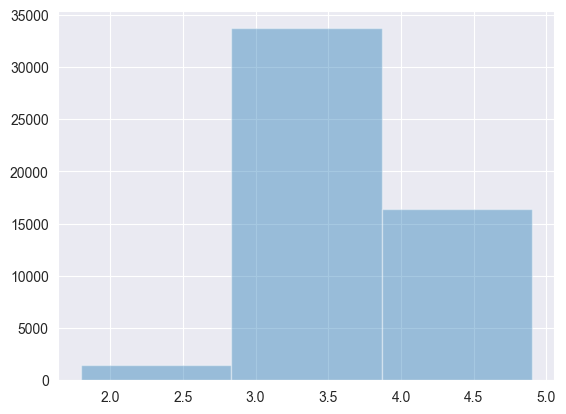

In [137]:
sns.distplot(x=df['rate'],kde=False,bins=3)
plt.show()

## Feature creation for rating

In [138]:
pd.cut(df['rate'],ordered=True,bins=3,precision=1)
df['rate_cat']=pd.cut(df['rate'],ordered=True,bins=3,precision=1)

0        (3.9, 4.9]
1        (3.9, 4.9]
2        (2.8, 3.9]
3        (2.8, 3.9]
4        (2.8, 3.9]
            ...    
51712    (2.8, 3.9]
51713    (2.8, 3.9]
51714    (2.8, 3.9]
51715    (3.9, 4.9]
51716    (2.8, 3.9]
Name: rate, Length: 51490, dtype: category
Categories (3, interval[float64, right]): [(1.8, 2.8] < (2.8, 3.9] < (3.9, 4.9]]

In [139]:
df['rate_cat'].cat.rename_categories(['low','medium','high'])
df['rate_cat']=df['rate_cat'].cat.rename_categories(['low','medium','high'])

0          high
1          high
2        medium
3        medium
4        medium
          ...  
51712    medium
51713    medium
51714    medium
51715      high
51716    medium
Name: rate_cat, Length: 51490, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']

In [140]:
df

,name,online_order,book_table,rate,votes,rest_type,cuisines,costfor2,type,location,rate_cat
0,Jalsa,Yes,Yes,4.1,775,Casual Dining,Others,800.0,Buffet,Banashankari,high
1,Spice Elephant,Yes,No,4.1,787,Casual Dining,Others,800.0,Buffet,Banashankari,high
2,San Churro Cafe,Yes,No,3.8,918,Others,Others,800.0,Buffet,Banashankari,medium
3,Addhuri Udupi Bhojana,No,No,3.7,88,Quick Bites,Others,300.0,Buffet,Banashankari,medium
4,Grand Village,No,No,3.8,166,Casual Dining,Others,600.0,Buffet,Banashankari,medium
...,...,...,...,...,...,...,...,...,...,...,...
51712,Best Brews - Four Points by Sheraton...,No,No,3.6,27,Others,Others,1500.0,Pubs and bars,Whitefield,medium
51713,Vinod Bar And Restaurant,No,No,3.7,0,Others,Others,600.0,Pubs and bars,Whitefield,medium
51714,Plunge - Sheraton Grand Bengaluru Wh...,No,No,3.7,0,Others,Others,2000.0,Pubs and bars,Whitefield,medium
51715,Chime - Sheraton Grand Bengaluru Whi...,No,Yes,4.3,236,Others,Others,2500.0,Pubs and bars,Whitefield,high


In [141]:
display(df.head(10).style.set_table_styles(table_styles['cerulean_palette']).set_caption("Zomato Data"))

,name,online_order,book_table,rate,votes,rest_type,cuisines,costfor2,type,location,rate_cat
0,Jalsa,Yes,Yes,4.100000,775,Casual Dining,Others,800.000000,Buffet,Banashankari,high
1,Spice Elephant,Yes,No,4.100000,787,Casual Dining,Others,800.000000,Buffet,Banashankari,high
2,San Churro Cafe,Yes,No,3.800000,918,Others,Others,800.000000,Buffet,Banashankari,medium
3,Addhuri Udupi Bhojana,No,No,3.700000,88,Quick Bites,Others,300.000000,Buffet,Banashankari,medium
4,Grand Village,No,No,3.800000,166,Casual Dining,Others,600.000000,Buffet,Banashankari,medium
5,Timepass Dinner,Yes,No,3.800000,286,Casual Dining,North Indian,600.000000,Buffet,Banashankari,medium
6,Rosewood International Hotel - Bar & Restaurant,No,No,3.600000,8,Casual Dining,Others,800.000000,Buffet,Banashankari,medium
7,Onesta,Yes,Yes,4.600000,2556,Others,Italian,600.000000,Cafes,Banashankari,high
8,Penthouse Cafe,Yes,No,4.000000,324,Cafe,Others,700.000000,Cafes,Banashankari,high
9,Smacznego,Yes,No,4.200000,504,Cafe,Others,550.000000,Cafes,Banashankari,high


In [142]:
display(df.describe().style.set_table_styles(table_styles['cerulean_palette']).set_caption("Zomato Data Summary Statistics"))

,rate,votes,costfor2
count,51490.000000,51490.000000,51490.000000
mean,3.701692,284.656283,555.694795
std,0.394904,805.439709,438.485411
min,1.800000,0.000000,40.000000
25%,3.500000,7.000000,300.000000
50%,3.700000,41.000000,400.000000
75%,3.900000,199.000000,700.000000
max,4.900000,16832.000000,6000.000000


## Visualizations of data distribution

<Axes: ylabel='rate'>

Text(0.5, 1.0, 'Boxplot of rating')

<Axes: ylabel='votes'>

Text(0.5, 1.0, 'Boxplot of Votes')

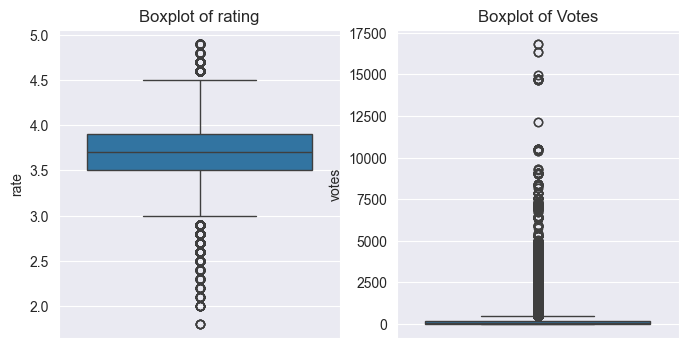

In [143]:

fig,axes=plt.subplots(1,2,figsize=(8,4))
sns.boxplot(y='rate',ax=axes[0],data=df)
axes[0].set_title('Boxplot of rating')
sns.boxplot(y='votes',ax=axes[1],data=df)
axes[1].set_title('Boxplot of Votes')


<Axes: xlabel='rest_type', ylabel='count'>

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Bakery'),
  Text(1, 0, 'Bar'),
  Text(2, 0, 'Cafe'),
  Text(3, 0, 'Casual Dining'),
  Text(4, 0, 'Delivery'),
  Text(5, 0, 'Dessert Parlor'),
  Text(6, 0, 'Others'),
  Text(7, 0, 'Quick Bites')])

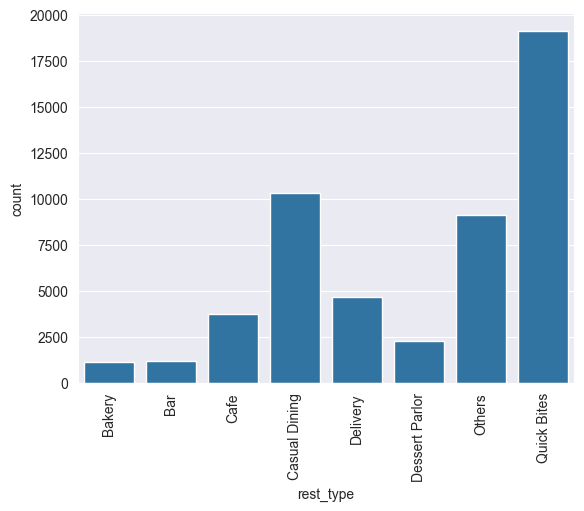

In [144]:
sns.set_style('darkgrid')
sns.countplot(x=df['rest_type'])
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='type', ylabel='count'>

Text(0.5, 1.0, 'Count of types of restaurant')

[Text(0, 0, 'Delivery'),
 Text(1, 0, 'Dine-out'),
 Text(2, 0, 'Desserts'),
 Text(3, 0, 'Cafes'),
 Text(4, 0, 'Drinks & nightlife'),
 Text(5, 0, 'Buffet'),
 Text(6, 0, 'Pubs and bars')]

<Axes: xlabel='location', ylabel='count'>

Text(0.5, 1.0, 'Count of number of restaurants in each area')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26],
 [Text(0, 0, 'BTM'),
  Text(1, 0, 'Banashankari'),
  Text(2, 0, 'Bannerghatta Road'),
  Text(3, 0, 'Basavanagudi'),
  Text(4, 0, 'Bellandur'),
  Text(5, 0, 'Brigade Road'),
  Text(6, 0, 'Brookefield'),
  Text(7, 0, 'Church Street'),
  Text(8, 0, 'Electronic City'),
  Text(9, 0, 'Frazer Town'),
  Text(10, 0, 'HSR'),
  Text(11, 0, 'Indiranagar'),
  Text(12, 0, 'JP Nagar'),
  Text(13, 0, 'Jayanagar'),
  Text(14, 0, 'Kalyan Nagar'),
  Text(15, 0, 'Kammanahalli'),
  Text(16, 0, 'Koramangala'),
  Text(17, 0, 'Lavelle Road'),
  Text(18, 0, 'MG Road'),
  Text(19, 0, 'Malleshwaram'),
  Text(20, 0, 'Marathahalli'),
  Text(21, 0, 'New BEL Road'),
  Text(22, 0, 'Old Airport Road'),
  Text(23, 0, 'Rajajinagar'),
  Text(24, 0, 'Residency Road'),
  Text(25, 0, 'Sarjapur Road'),
  Text(26, 0, 'Whitefield')])

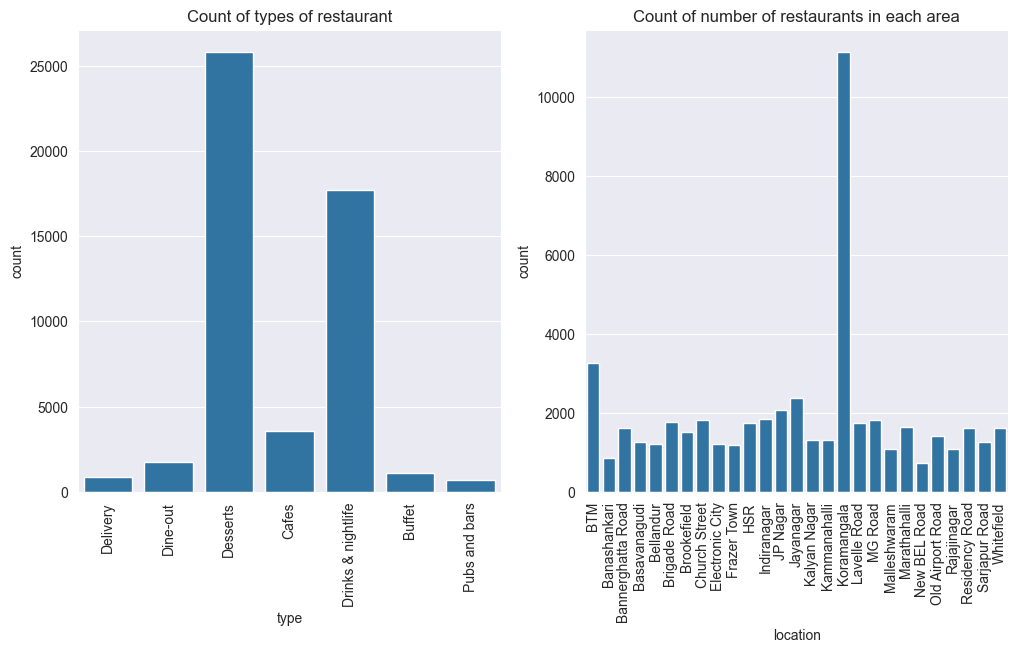

In [145]:

fig,axes=plt.subplots(1,2,figsize=(12,6))
sns.countplot(x=df['type'],ax=axes[0])
axes[0].set_title("Count of types of restaurant")
axes[0].set_xticklabels(df['type'].value_counts().index, rotation=90)
sns.countplot(x=df['location'],ax=axes[1])
axes[1].set_title("Count of number of restaurants in each area")
plt.xticks(rotation=90)
plt.show()

rate_cat,rest_type,low,medium,high
0,Bakery,0.003506,0.860649,0.135846
1,Bar,0.018198,0.226170,0.755633
2,Cafe,0.031083,0.466774,0.502144
3,Casual Dining,0.051694,0.512004,0.436302
4,Delivery,0.025210,0.834303,0.140487
5,Dessert Parlor,0.003093,0.514361,0.482545
6,Others,0.019347,0.514455,0.466198
7,Quick Bites,0.023259,0.821556,0.155185
8,All,0.027578,0.654651,0.317770


<Axes: xlabel='rate_cat', ylabel='rest_type'>

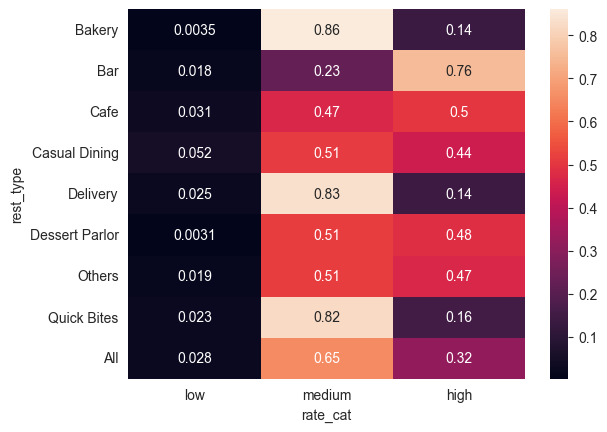

In [146]:
pd.crosstab(df['rest_type'],df['rate_cat'],normalize='index',margins=True).reset_index()
sns.heatmap(pd.crosstab(df['rest_type'],df['rate_cat'],normalize='index',margins=True), annot=True)

In [147]:
pd.crosstab(df['location'],df['rate_cat']).sort_values(by='high',ascending=False)

rate_cat,low,medium,high
location,,,
Koramangala,229,6993,3910
BTM,81,2163,1021
MG Road,49,949,810
Church Street,43,991,792
Brigade Road,43,949,775
Indiranagar,62,1042,747
Jayanagar,57,1581,728
Lavelle Road,40,991,710
Residency Road,39,905,673


In [148]:
df_copy=df.copy()

In [149]:
# There's some duplicates in the data, let's remove those for more accurate visualizations
df.duplicated().value_counts()
df.drop_duplicates(keep='first',inplace=True)

False    45632
True      5858
Name: count, dtype: int64

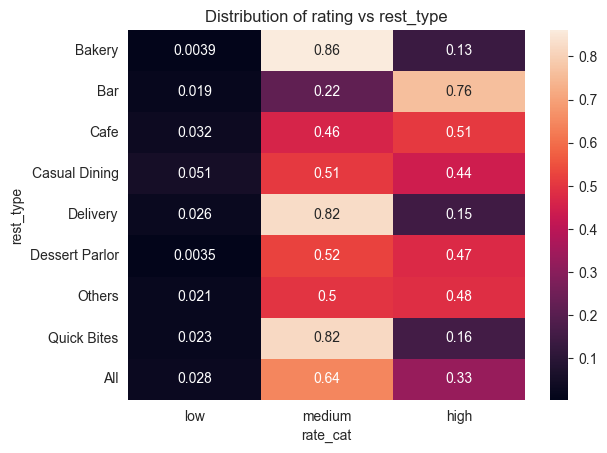

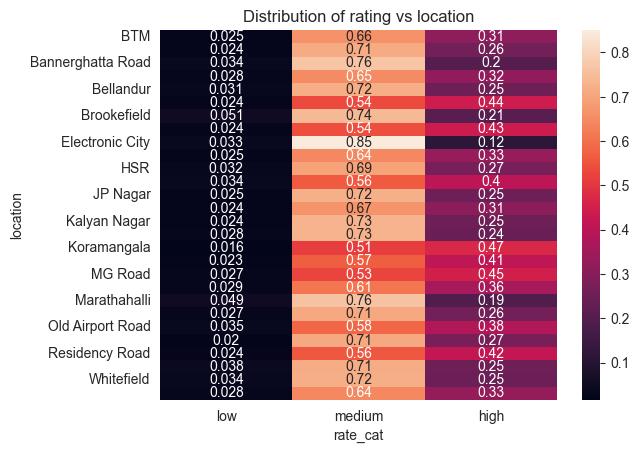

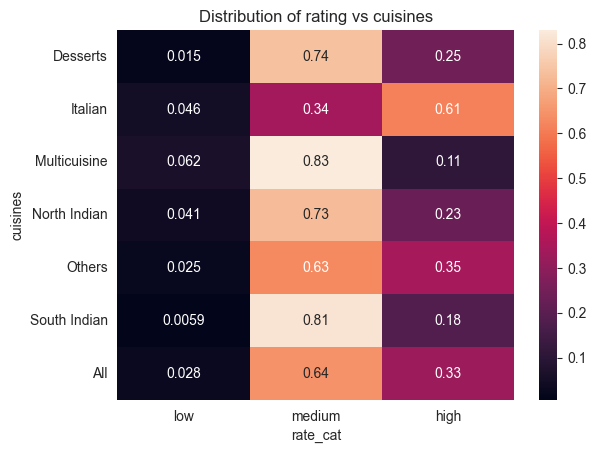

In [150]:

# Let's check the rating category vs categorical fetaures rest_type,cuisines,location
# Rating usually depends on these criteria
category=['rest_type','location','cuisines']

def heatmaps(cat):
    table=pd.crosstab(df[cat],df['rate_cat'],normalize='index',margins=True)
    sns.heatmap(table,annot=True)
    plt.title(f'Distribution of rating vs {cat}')
    plt.show()

for cat in category:
    heatmaps(cat)


<Axes: >

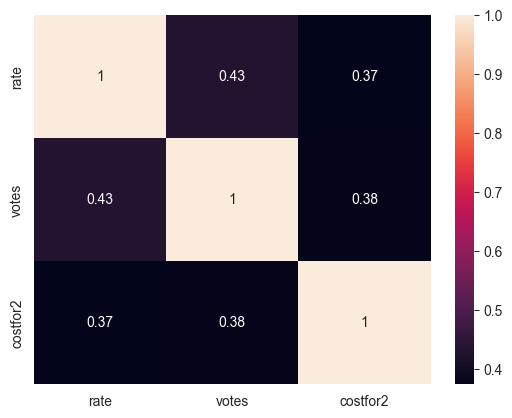

In [151]:
sns.heatmap(df.select_dtypes(include=np.number).corr(),annot=True)

In [152]:
df.groupby('location')['votes'].sum().sort_values(ascending=False).reset_index()

,location,votes
0,Koramangala,3184557
1,BTM,976846
2,Indiranagar,779608
3,MG Road,719636
4,Church Street,671542
5,Brigade Road,646419
6,Residency Road,587698
7,Lavelle Road,582247
8,Old Airport Road,578300
9,Jayanagar,562462


In [153]:
df

,name,online_order,book_table,rate,votes,rest_type,cuisines,costfor2,type,location,rate_cat
0,Jalsa,Yes,Yes,4.1,775,Casual Dining,Others,800.0,Buffet,Banashankari,high
1,Spice Elephant,Yes,No,4.1,787,Casual Dining,Others,800.0,Buffet,Banashankari,high
2,San Churro Cafe,Yes,No,3.8,918,Others,Others,800.0,Buffet,Banashankari,medium
3,Addhuri Udupi Bhojana,No,No,3.7,88,Quick Bites,Others,300.0,Buffet,Banashankari,medium
4,Grand Village,No,No,3.8,166,Casual Dining,Others,600.0,Buffet,Banashankari,medium
...,...,...,...,...,...,...,...,...,...,...,...
51712,Best Brews - Four Points by Sheraton...,No,No,3.6,27,Others,Others,1500.0,Pubs and bars,Whitefield,medium
51713,Vinod Bar And Restaurant,No,No,3.7,0,Others,Others,600.0,Pubs and bars,Whitefield,medium
51714,Plunge - Sheraton Grand Bengaluru Wh...,No,No,3.7,0,Others,Others,2000.0,Pubs and bars,Whitefield,medium
51715,Chime - Sheraton Grand Bengaluru Whi...,No,Yes,4.3,236,Others,Others,2500.0,Pubs and bars,Whitefield,high


<Axes: xlabel='online_order', ylabel='count'>

Text(0.5, 1.0, 'Count of restaurants which has online delivery')

<Axes: xlabel='book_table', ylabel='count'>

Text(0.5, 1.0, 'Count of restaurants which allows booking table')

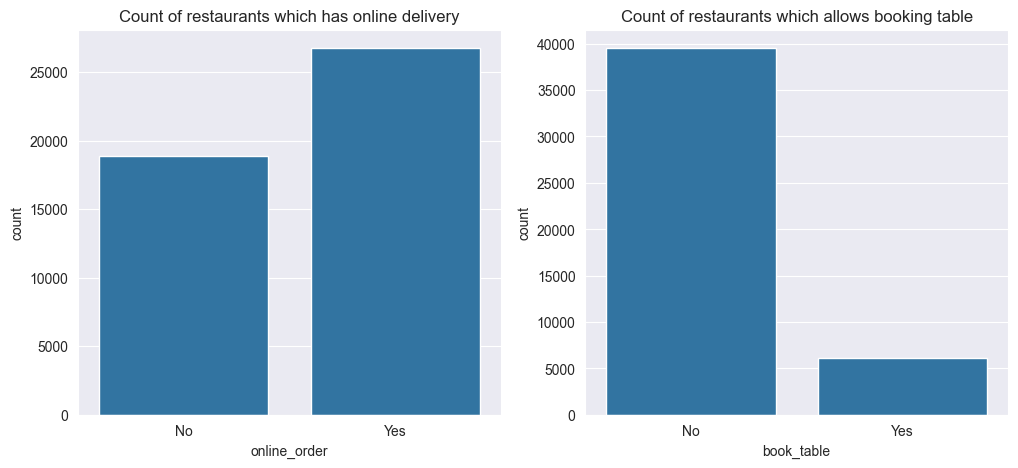

In [154]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
sns.countplot(x=df['online_order'],ax=axes[0])
axes[0].set_title("Count of restaurants which has online delivery")
sns.countplot(x=df['book_table'],ax=axes[1])
axes[1].set_title("Count of restaurants which allows booking table")

<Axes: xlabel='location', ylabel='count'>

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26],
 [Text(0, 0, 'BTM'),
  Text(1, 0, 'Banashankari'),
  Text(2, 0, 'Bannerghatta Road'),
  Text(3, 0, 'Basavanagudi'),
  Text(4, 0, 'Bellandur'),
  Text(5, 0, 'Brigade Road'),
  Text(6, 0, 'Brookefield'),
  Text(7, 0, 'Church Street'),
  Text(8, 0, 'Electronic City'),
  Text(9, 0, 'Frazer Town'),
  Text(10, 0, 'HSR'),
  Text(11, 0, 'Indiranagar'),
  Text(12, 0, 'JP Nagar'),
  Text(13, 0, 'Jayanagar'),
  Text(14, 0, 'Kalyan Nagar'),
  Text(15, 0, 'Kammanahalli'),
  Text(16, 0, 'Koramangala'),
  Text(17, 0, 'Lavelle Road'),
  Text(18, 0, 'MG Road'),
  Text(19, 0, 'Malleshwaram'),
  Text(20, 0, 'Marathahalli'),
  Text(21, 0, 'New BEL Road'),
  Text(22, 0, 'Old Airport Road'),
  Text(23, 0, 'Rajajinagar'),
  Text(24, 0, 'Residency Road'),
  Text(25, 0, 'Sarjapur Road'),
  Text(26, 0, 'Whitefield')])

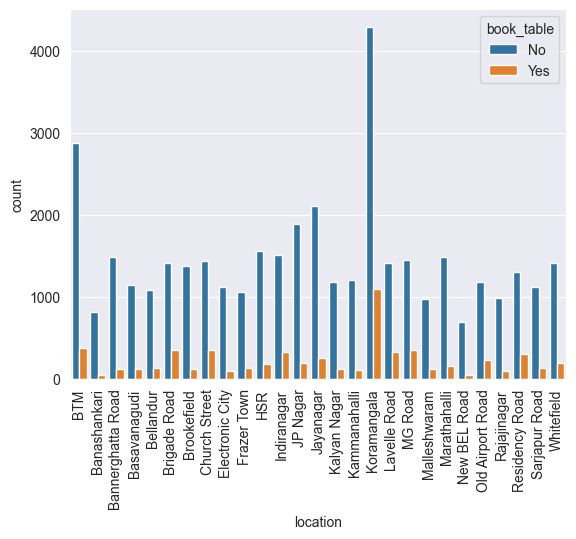

In [155]:
sns.countplot(x=df['location'],hue=df['book_table'])
plt.xticks(rotation=90)

<Axes: xlabel='rest_type', ylabel='count'>

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Bakery'),
  Text(1, 0, 'Bar'),
  Text(2, 0, 'Cafe'),
  Text(3, 0, 'Casual Dining'),
  Text(4, 0, 'Delivery'),
  Text(5, 0, 'Dessert Parlor'),
  Text(6, 0, 'Others'),
  Text(7, 0, 'Quick Bites')])

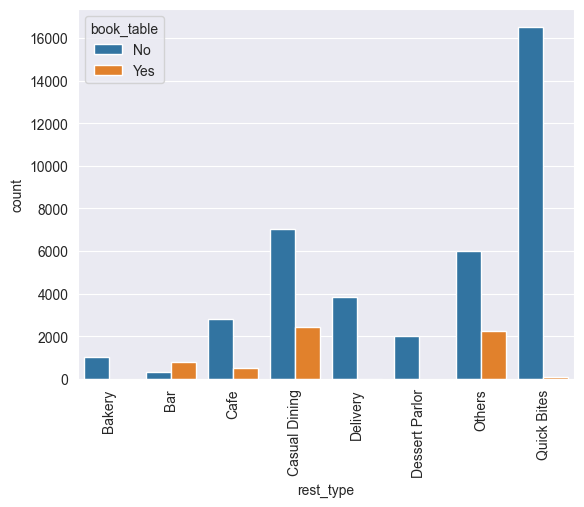

In [156]:
sns.countplot(x=df['rest_type'],hue=df['book_table'])
plt.xticks(rotation=90)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   location  27 non-null     category
 1   costfor2  27 non-null     float64 
dtypes: category(1), float64(1)
memory usage: 1.6 KB


<Axes: xlabel='location', ylabel='costfor2'>

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26],
 [Text(0, 0, 'Church Street'),
  Text(1, 0, 'Brigade Road'),
  Text(2, 0, 'MG Road'),
  Text(3, 0, 'Lavelle Road'),
  Text(4, 0, 'Residency Road'),
  Text(5, 0, 'Indiranagar'),
  Text(6, 0, 'Old Airport Road'),
  Text(7, 0, 'Koramangala'),
  Text(8, 0, 'Whitefield'),
  Text(9, 0, 'Malleshwaram'),
  Text(10, 0, 'Frazer Town'),
  Text(11, 0, 'Bellandur'),
  Text(12, 0, 'Sarjapur Road'),
  Text(13, 0, 'Brookefield'),
  Text(14, 0, 'Electronic City'),
  Text(15, 0, 'Marathahalli'),
  Text(16, 0, 'BTM'),
  Text(17, 0, 'HSR'),
  Text(18, 0, 'Rajajinagar'),
  Text(19, 0, 'Kalyan Nagar'),
  Text(20, 0, 'Kammanahalli'),
  Text(21, 0, 'Jayanagar'),
  Text(22, 0, 'JP Nagar'),
  Text(23, 0, 'New BEL Road'),
  Text(24, 0, 'Bannerghatta Road'),
  Text(25, 0, 'Basavanagudi'),
  Text(26, 0, 'Banashankari')])

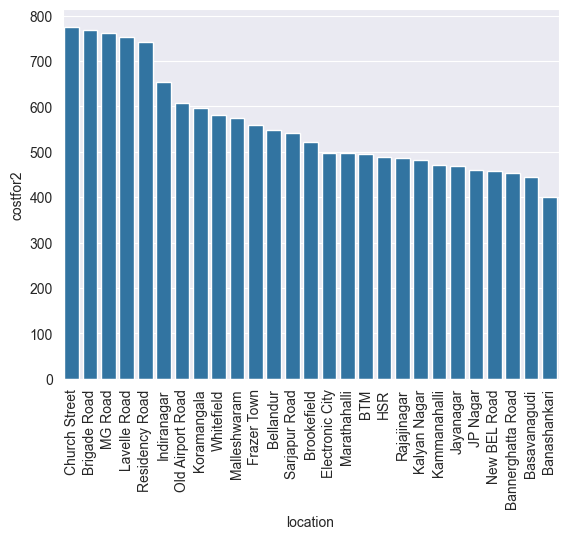

In [157]:
loc_cost=df.groupby('location')['costfor2'].mean().reset_index()
loc_cost.info()
order_list =df.groupby('location')['costfor2'].mean().\
reset_index().sort_values(by='costfor2',ascending=False)['location'].to_list()
sns.barplot(x=loc_cost['location'],y=loc_cost['costfor2'],order=order_list)
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='location', ylabel='rate'>

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26],
 [Text(0, 0, 'Brigade Road'),
  Text(1, 0, 'Church Street'),
  Text(2, 0, 'Lavelle Road'),
  Text(3, 0, 'Residency Road'),
  Text(4, 0, 'Koramangala'),
  Text(5, 0, 'MG Road'),
  Text(6, 0, 'Basavanagudi'),
  Text(7, 0, 'HSR'),
  Text(8, 0, 'Banashankari'),
  Text(9, 0, 'Frazer Town'),
  Text(10, 0, 'BTM'),
  Text(11, 0, 'Rajajinagar'),
  Text(12, 0, 'Malleshwaram'),
  Text(13, 0, 'Old Airport Road'),
  Text(14, 0, 'Indiranagar'),
  Text(15, 0, 'Jayanagar'),
  Text(16, 0, 'Kalyan Nagar'),
  Text(17, 0, 'Kammanahalli'),
  Text(18, 0, 'Bannerghatta Road'),
  Text(19, 0, 'Electronic City'),
  Text(20, 0, 'Brookefield'),
  Text(21, 0, 'Bellandur'),
  Text(22, 0, 'JP Nagar'),
  Text(23, 0, 'New BEL Road'),
  Text(24, 0, 'Marathahalli'),
  Text(25, 0, 'Sarjapur Road'),
  Text(26, 0, 'Whitefield')])

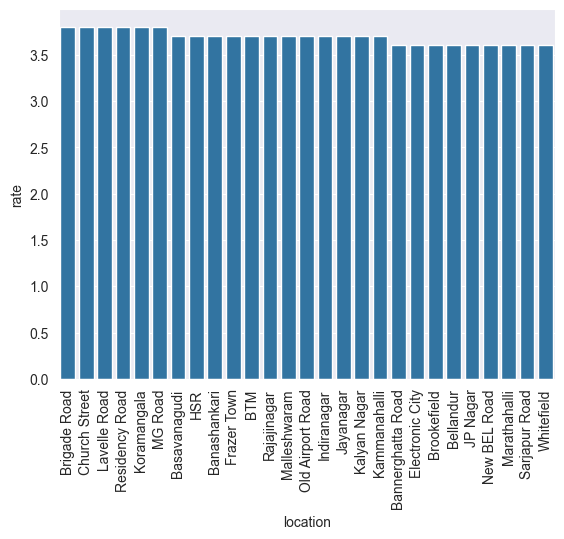

In [158]:
loc_rating = round(df.groupby('location')['rate'].mean(),1).reset_index()
order_list=loc_rating.sort_values(by='rate',ascending=False)['location'].to_list()
sns.barplot(x=loc_rating['location'],y=loc_rating['rate'],order=order_list)
plt.xticks(rotation=90)

<Axes: xlabel='rest_type', ylabel='costfor2'>

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Bar'),
  Text(1, 0, 'Casual Dining'),
  Text(2, 0, 'Cafe'),
  Text(3, 0, 'Others'),
  Text(4, 0, 'Bakery'),
  Text(5, 0, 'Delivery'),
  Text(6, 0, 'Dessert Parlor'),
  Text(7, 0, 'Quick Bites')])

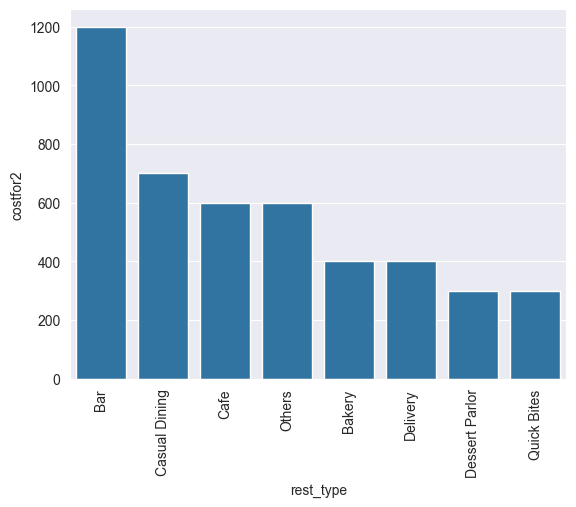

In [159]:
cost_df=df.groupby('rest_type')['costfor2'].median().reset_index()
order_list= cost_df.sort_values(by='costfor2',ascending=False)['rest_type'].to_list()
sns.barplot(x=cost_df['rest_type'],y=cost_df['costfor2'],order=order_list)
plt.xticks(rotation=90)
plt.show()

In [160]:
groupby=df.groupby(['location','cuisines']).agg(count=('name','count')).reset_index()
idx=groupby.groupby('location')['count'].idxmax()
groupby.loc[idx,['location','cuisines','count']]

,location,cuisines,count
4,BTM,Others,2607
10,Banashankari,Others,622
16,Bannerghatta Road,Others,1270
22,Basavanagudi,Others,946
28,Bellandur,Others,886
34,Brigade Road,Others,1444
40,Brookefield,Others,1119
46,Church Street,Others,1463
52,Electronic City,Others,939
58,Frazer Town,Others,937


In [161]:
idx=df.groupby(['location','cuisines'])['rate'].idxmax()
top_restaurants=df.loc[idx,['name','location','cuisines','rate']]
top_restaurants

,name,location,cuisines,rate
8585,Occasions,BTM,Desserts,4.3
8337,Stoner,BTM,Italian,4.5
9337,Noon's,BTM,Multicuisine,4.2
8278,Punjab Bistro,BTM,North Indian,4.4
8260,AB's - Absolute Barbecues,BTM,Others,4.9
...,...,...,...,...
50098,Bloomsbury's Global Kitchen & Bakehouse,Whitefield,Italian,4.5
50243,Biryani Kitchen,Whitefield,Multicuisine,4.3
50266,Punjab Grill,Whitefield,North Indian,4.8
51042,Flechazo,Whitefield,Others,4.9


### The above top_restaurants df gives us the highest rated restaurants for each location and cuisine.
* The highest rated restaurant in BTM is Abs absolute barbeques
* Bloomberry's global kitchen is the highest rated italian restaurant in whitefield
* Oota Bangalore is the highest rated south indian restaurant in whitefield.
* Others include a mix of cusisines, the above data shows that Bangalore has the most number of mix type of cuisines as it is a silicon valley so has a very diverse population.


In [162]:
# df[df['cuisines']=='South Indian']['rate'].idxmax()
# df.loc[df[df['cuisines']=='South Indian']['rate'].idxmax(),['name']]

def best_place(list1):
    for val in list1:
        df[df['cuisines']==val]['rate'].idxmax()
        print(f"{val} - {df.loc[df[df['cuisines']==val]['rate'].idxmax(),['name']]})")
    
cuisines_list=df['cuisines'].value_counts().index.to_list()
best_place(cuisines_list)
cuisines_list

Others - name    Byg Brewski Brewing Company
Name: 3921, dtype: object)
Multicuisine - name    Nakkshatra
Name: 41545, dtype: object)
North Indian - name    Punjab Grill
Name: 7118, dtype: object)
Italian - name    The Pizza Bakery
Name: 18185, dtype: object)
South Indian - name    Brahmin's Coffee Bar
Name: 3338, dtype: object)
Desserts - name    O.G. Variar & Sons
Name: 40068, dtype: object)


['Others',
 'Multicuisine',
 'North Indian',
 'Italian',
 'South Indian',
 'Desserts']

## Best restaurants in Bangalore based on Cuisines
* Top most rated restaurant in **Multicuisine category** - Nakkshatra
* Top most rated restaurant in **North Indian category** - Punjab Grill
* Top most rated restaurant in **Italian category** - The Pizza Bakery
* Top most rated restaurant in **South Indian category** - Brahmin's Coffee Bar
* Top most rated restaurant in **Desserts category** - O.G. Variar & Sons
* Top most rated restaurant in **Others category** - Byg Brewski Brewing Company

## Major observations and Insights from the above visualizations/analysis
*  The median rating of all the restaurants in Bangalore is around 3.7/5.
*  The most common types of restaurants in Bangalore comes under quick bites and casual dining.
*  Koramangala and BTM are the top 2 areas with most number of restaurants.
*  Italian cuisines are generally rated high as can be seen by rating vs cuisines heatmap, where we can see positive correlation of 0.61
* More than 50% restaurants in Bangalore provide online delivery facility. (Can be seen by the countplot)
* The most expensive restaurants of Bangalore are mostly located in these 4 areas: 1) Chruch Street, 2) Brigade Road, 3) MG Road, 4) Lavelle Road. (Can be seen from the countplot above)
* The top rated restaurants are found in these 4 locations 1) Koramangala, 2) Chruch Street, 3) MG Road and 4) Residency road. (Can be seen from the countplot above)
* The types of restaurants which are heavy for the pocket are 1) Bar followed by 2) Casual dining followed by 3) Cafes. (Can be seen by the barplot above)
* The majority of restaurants are rated 3.9, followed by 3.8 and 3.7, which are decent ratings. This means that most of the restaurants at Bangalore are liked by the citizens and hence rated above average. This shows that due to high rise in the number of restaurants in Bangalore there is tough competition between restaurants as they are trying to excel in quality and services to increase the number of customers.

## Hypothesis Testing

In [163]:
# Checking if cuisine has an impact on the rating of the restaurant

# H0 : There is no association of rating category on cuisine
# H1 : There is an association of rating category on cuisine

alpha = 0.05

contingency_table=pd.crosstab(df['cuisines'],df['rate_cat'],normalize=True)

stat,pval,dof,feq=scipy.stats.chi2_contingency(contingency_table)

if pval<alpha:
    print(f"{pval} - There is an association of rating category on cuisine")
else:
    print(f"{pval} - There is no association of rating category on cuisine") 

0.9999999999691384 - There is no association of rating category on cuisine


In [164]:
# Since Bangalore is a south Indian city let's see if the rating of south Indian retaurants
# are more in comparison to North Indian cuisine

# H0 : Mean rating of South Indian cuisine is equal to North Indian cuisine
# HA : Mean rating of South Indian cuisine > North Indian cuisine

alpha = 0.05

# To decrease the bias I have taken the same sample size for both the cuisines

south = df[df['cuisines']=='South Indian']['rate'].sample(1686)
north = df[df['cuisines']=='North Indian']['rate'].sample(1686)

south.std()
north.std()
# Variance is almost equal for South and North Indian restaurants

tstat,pval = scipy.stats.ttest_ind(south,north,equal_var=True,alternative='greater')

if pval<alpha:
    print(f"{pval} - Mean rating of South Indian cuisine > North Indian cuisine")
else:
    print(f"{pval} - Mean rating of South Indian cuisine is equal to North Indian cuisine")

np.float64(0.31007277538274736)

np.float64(0.37773876658385985)

0.0007071790293401145 - Mean rating of South Indian cuisine > North Indian cuisine


rest_type
Quick Bites       16620
Casual Dining      9444
Others             8272
Delivery           3862
Cafe               3310
Dessert Parlor     1998
Bar                1096
Bakery             1030
Name: count, dtype: int64

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

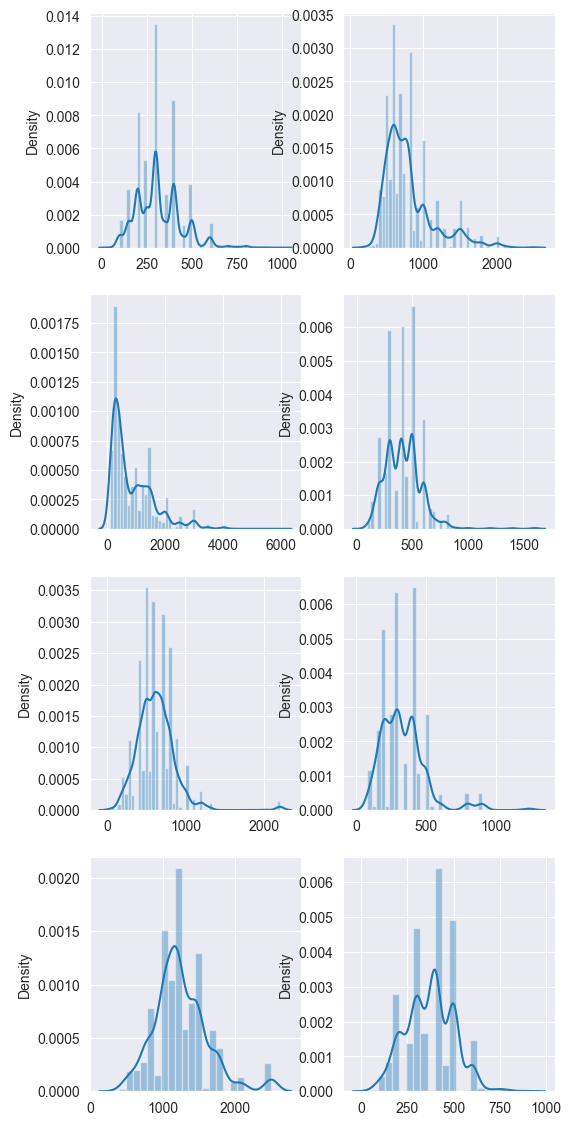

In [165]:


# Let's check whether mean of cost for 2 people varies according to the restaurant type

# H0 : The mean of cost for 2 people is same for all the restaurant types
# HA : The mean of cost for 2 people is not same for all the restaurant types

alpha = 0.05

list_rest=df['rest_type'].value_counts().index.to_list()

def list_return(val):
    return df[df['rest_type']==val]['costfor2'].to_list()
    
df['rest_type'].value_counts()

# Since there are more than 2 numerical values we can apply Anova test

# Assumptions of Anova are 
# 1) The data must be normally distributed
# 2) The variances among different groups should be equal
# 3) The observations within each group are independent of each other.
# 4) The data are collected using random sampling methods, 
#    ensuring that the sample is representative of the population from which it is drawn.

# Checking for normality of data 

fig,axes=plt.subplots(4,2,figsize=(6,14))
sns.distplot(list_return('Quick Bites'),ax=axes[0,0])
sns.distplot(list_return('Casual Dining'),ax=axes[0,1])
sns.distplot(list_return('Others'),ax=axes[1,0])
sns.distplot(list_return('Delivery'),ax=axes[1,1])
sns.distplot(list_return('Cafe'),ax=axes[2,0])
sns.distplot(list_return('Dessert Parlor'),ax=axes[2,1])
sns.distplot(list_return('Bar'),ax=axes[3,0])
sns.distplot(list_return('Bakery'),ax=axes[3,1])
plt.show()

In [166]:
# As can be seen by above graph none of the restaurant type data looks normal

# Let's verify using the shapiro wilk test 

alpha = 0.05

stat,pval=scipy.stats.shapiro(list_return('Quick Bites'))

if pval<alpha:
    print("Data not normal")
else:
    print("Data is normal")

Data not normal


In [167]:
# The data is not normal, let's see if variances are equal or not

# Let's perform Levene's test for the same

lstat,pval=scipy.stats.levene(list_return('Quick Bites'),list_return('Casual Dining'),\
                  list_return('Others'),list_return('Delivery'),list_return('Cafe'),\
                list_return('Dessert Parlor'),list_return('Bar'),list_return('Bakery'))
alpha = 0.05

if pval<0.05:
    print("Variances are not equal")
else:
    print("Variances are equal")


Variances are not equal


In [168]:
# Since the assumptions of Anova did not hold true, let's perform Kruskal Wallis test
import random
quick_bites = list_return('Quick Bites')
casual= list_return('Casual Dining')
others = list_return('Others')
delivery = list_return('Delivery')
cafe = list_return('Cafe')
dessert = list_return('Dessert Parlor')
bar = list_return('Bar')
bakery = list_return('Bakery')
kstat,pval=scipy.stats.kruskal(random.sample(quick_bites,1030),random.sample(casual,1030),\
                               random.sample(others,1030),\
                  random.sample(delivery,1030),random.sample(cafe,1030),\
                               random.sample(dessert,1030),\
                  random.sample(bar,1030),random.sample(bakery,1030))

alpha = 0.05 

if pval<alpha:
    print("The mean of cost for 2 people is not same for all the restaurant types")
else:
    print("The mean of cost for 2 people is same for all the restaurant types")

The mean of cost for 2 people is not same for all the restaurant types


## Observations from Hypothesis testing
* The mean cost for 2 people varies with restaurant type i.e causal dining/bar/cafe etc.
* The mean rating of South Indian restaurants is more than North Indian restaurants.
* On overall level there is no association with rating and cuisine.
* The cost for 2 people data is not normally distributed.

## Conclusion
#### The Zomato Bangalore dataset was analysed to understand people’s choice of cuisine, dining type, preference for location according to price etc. It will really help the upcoming new restaurants to decide the people’s preference for cuisine, dinning type.We find some great results like which area has the most number of restaurants , which are the top rated restaurant in a given area for a given cuisine type, what all cuisines are mostly preferred by people ,which are the cheapest areas for having food etc.